<a href="https://colab.research.google.com/github/moradsab/Cinema/blob/master/Depth_NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

In [ ]:
!pip install imageio-ffmpeg


In [ ]:
!git clone https://github.com/isl-org/redwood-3dscan
%cd /content/redwood-3dscan

In [ ]:
import redwood_3dscan as rws

# e.g. some RGBD images may not come with mesh.
rws.download_rgbd("00033")  # Save to data/rgbd/00033.zip, if available
rws.download_mesh("00033")  # Save to data/mesh/00033.ply, if available

In [ ]:
!unzip '/content/redwood-3dscan/data/rgbd/00033.zip'

In [ ]:
import os
import cv2
import numpy as np

def calculate_camera_poses(image_files, rgb_directory, focal, principal_point):
    # Initialize camera poses with the identity matrix
    poses = [np.eye(4)]

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    for i in range(1, len(image_files)):
        # Load previous and current images
        prev_image = cv2.imread(os.path.join(rgb_directory, image_files[i - 1]), cv2.IMREAD_GRAYSCALE)
        curr_image = cv2.imread(os.path.join(rgb_directory, image_files[i]), cv2.IMREAD_GRAYSCALE)

        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(prev_image, None)
        kp2, des2 = sift.detectAndCompute(curr_image, None)

        # FLANN-based matching
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Apply ratio test as per Lowe's paper
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # Extract matched points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Estimate Essential Matrix
        E, mask = cv2.findEssentialMat(src_pts, dst_pts, focal=focal, pp=principal_point)

        # Recover poses
        _, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, focal=focal, pp=principal_point)

        # Create a relative pose matrix
        relative_pose = np.eye(4)
        relative_pose[:3, :3] = R
        relative_pose[:3, 3] = t.ravel()

        # Calculate the current camera pose by multiplying with the previous pose
        current_pose = poses[-1].dot(relative_pose)
        poses.append(current_pose)

    return poses


# Focal length and principal point
focal = 525.0
principal_point = (319.5, 239.5)


rgb_directory = '/content/redwood-3dscan/rgb'
image_files = sorted(os.listdir(rgb_directory))
camera_poses = calculate_camera_poses(image_files, rgb_directory, focal, principal_point)
camera_poses = np.array(camera_poses, dtype=np.float32)


In [ ]:

def calculate_camera_poses(image_files, rgb_directory, focal_length, principal_point):
    # Initialize camera poses with the identity matrix
    poses = [np.eye(4)]

    # Create ORB detector and BFMatcher
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for i in range(1, len(image_files)):
        # Load previous and current images
        prev_image = cv2.imread(os.path.join(rgb_directory, image_files[i - 1]))
        curr_image = cv2.imread(os.path.join(rgb_directory, image_files[i]))

        # Convert images to grayscale
        prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)

        # Find ORB keypoints and descriptors for both images
        kp1, des1 = orb.detectAndCompute(prev_gray, None)
        kp2, des2 = orb.detectAndCompute(curr_gray, None)

        # Match keypoints between the two images
        matches = bf.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)[:50]

        # Extract matched points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Estimate Essential Matrix
        E, mask = cv2.findEssentialMat(src_pts, dst_pts, focal=focal_length, pp=principal_point)

        # Recover pose
        _, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, focal=focal_length, pp=principal_point)

        # Create a relative pose matrix
        relative_pose = np.eye(4)
        relative_pose[:3, :3] = R
        relative_pose[:3, 3] = t.ravel()

        # Calculate the current camera pose by multiplying with the previous pose
        current_pose = poses[-1].dot(relative_pose)
        poses.append(current_pose)

    return poses


# Focal length and principal point
focal = 525.0
principal_point = (319.5, 239.5)


rgb_directory = '/content/redwood-3dscan/rgb'
image_files = sorted(os.listdir(rgb_directory))
camera_poses = calculate_camera_poses(image_files, rgb_directory, focal, principal_point)
camera_poses = np.array(camera_poses, dtype=np.float32)

In [ ]:
def load_rgb_images(rgb_directory):
    target_size = (100, 100)
    # Load the images
    rgb_images = [cv2.imread(os.path.join(rgb_directory, f)) for f in sorted(os.listdir(rgb_directory))]

    # Resize the images
    resized_images = [cv2.resize(img, target_size) for img in rgb_images]

    return np.array(resized_images)

rgb_images = load_rgb_images(rgb_directory)

In [ ]:
# Save data
np.savez('data.npz', camera_poses=camera_poses, rgb_images=rgb_images)

(1877, 100, 100, 3) (1877, 4, 4) 525.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> 525.0
(100, 100, 100, 3) (100, 4, 4) 525.0


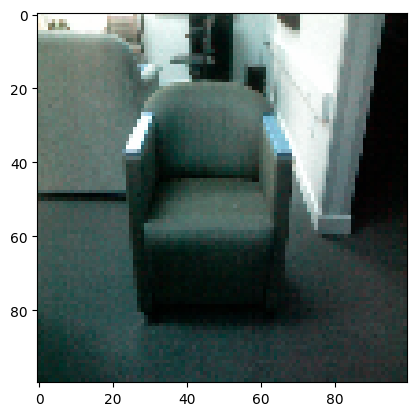

In [ ]:
data = np.load('data.npz')
poses = data['camera_poses']
images = data['rgb_images']
focal = np.array(525.0)
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)
print( type(poses[0]), type(focal),focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

print(images.shape, poses.shape, focal)

plt.imshow(testimg)
plt.show()

In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
        # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(depth)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

KeyboardInterrupt: ignored